In [1]:
import numpy as np
import Scripts.cifar_resnet as rn
import Scripts.wake_processing as wp
import importlib
import Scripts.autoencoder as ae
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
%matplotlib inline

In [2]:
importlib.reload(rn)
importlib.reload(wp)

<module 'Scripts.wake_processing' from 'E:\\Studies\\Deep Water\\DeepWater\\Scripts\\wake_processing.py'>

## Training Data

In [3]:
real_wakes_data = np.load("Data\\Wake data\\confirmed_wakes.npy")
generated_wakes = np.load("Data\\Wake data\\generated_wakes_1000.npy")
not_wakes_day_data = np.load("Data\\Wake data\\negative_samples_3000_day.npy")
not_wakes_all_data = np.load("Data\\Wake data\\negative_samples_3000.npy")
real_wakes = real_wakes_data[:,:,:-1,:]
not_wakes = not_wakes_day_data[:,:,:-1,:]
not_wakes_all = not_wakes_day_data[:,:,:-1,:]

## Train function

In [4]:
def train_rn(model, train_data, test_data, num_epochs=5, batch_size=5, learning_rate=1e-3):
    model = model.to(device)
    torch.manual_seed(0)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=0, drop_last=True)
    X_val, y_val = test_data.tensors[0].to(device), test_data.tensors[1].to(device)
    train_losses = []
    val_losses = []
    val_accs = []
    train_accs= []
    for epoch in range(num_epochs):
        total_loss = []
        batch_accs = []
        for i, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_pred_label = 1 - torch.argmax(pred, dim = 1).cpu().detach().numpy()
            train_true_label = 1 - torch.argmax(y, dim = 1).cpu().detach().numpy()
            batch_acc = accuracy_score(train_true_label, train_pred_label)
            batch_accs.append(batch_acc)
            total_loss.append(loss.item())
            
        val_pred = model(X_val)
        val_pred_label = 1 - torch.argmax(val_pred, dim = 1).cpu().detach().numpy()
        val_true_label = 1 - torch.argmax(y_val, dim = 1).cpu().detach().numpy()
        val_loss = criterion(val_pred, y_val).item()
        train_loss = sum(total_loss)/len(total_loss)
        train_acc = sum(batch_accs)/len(batch_accs)
        val_acc = accuracy_score(val_true_label, val_pred_label)
        print('Epoch:{}, Loss:{:.4f}, Val Loss:{:.4f}, Train Acc:{:4f}, Val Acc:{:.4f}'.format(epoch+1, train_loss,
                                                                                               val_loss, train_acc, val_acc))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)
    return train_losses, val_losses, train_accs, val_accs

In [5]:
def make_plots(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(10,6))
    plt.plot(train_losses, label = 'Train loss')
    plt.plot(val_losses, label = 'Validation loss')
    plt.legend(loc = 'upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Binary Cross-entropy loss')
    plt.show()
    plt.figure(figsize=(10,6))
    plt.plot(train_accs, label = 'Train accuracy')
    plt.plot(val_accs, label = 'Validation accuracy')
    plt.legend(loc = 'upper left')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 25

In [7]:
RS = 17

## Experiment 1
### Training: 500 positive (113 real + 387 generated) and 500 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative

In [8]:
train_real, test_real = train_test_split(real_wakes, test_size=0.2, random_state=RS)
train_gen, test_gen = train_test_split(generated_wakes, train_size = 0.387, test_size=0.046, random_state=RS)
train_neg, test_neg = train_test_split(not_wakes, train_size = 1/6, test_size = 75/3000, random_state = RS)

In [9]:
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = np.append(train_real, train_gen, axis = 0)
test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
test_y_exp_1 = test_y
test_x_exp_1 = test_x
train_y = np.append(train_pos_y, train_neg_y, axis = 0)

In [10]:
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [11]:
resnet_1 = None
resnet_1 = rn.ResNet18()
train_losses, val_losses, train_accs, val_accs = train_rn(resnet_1, train_dataset, test_dataset, num_epochs = num_epochs, learning_rate=1e-4)

Epoch:1, Loss:0.3014, Val Loss:0.1432, Train Acc:0.881000, Val Acc:0.9733
Epoch:2, Loss:0.1961, Val Loss:0.1214, Train Acc:0.927000, Val Acc:0.9733
Epoch:3, Loss:0.1386, Val Loss:0.1193, Train Acc:0.947000, Val Acc:0.9600
Epoch:4, Loss:0.0740, Val Loss:0.1218, Train Acc:0.977000, Val Acc:0.9600
Epoch:5, Loss:0.0196, Val Loss:0.1443, Train Acc:0.996000, Val Acc:0.9667
Epoch:6, Loss:0.0300, Val Loss:0.1201, Train Acc:0.991000, Val Acc:0.9400
Epoch:7, Loss:0.0162, Val Loss:0.2106, Train Acc:0.996000, Val Acc:0.9533
Epoch:8, Loss:0.0246, Val Loss:0.1619, Train Acc:0.991000, Val Acc:0.9467
Epoch:9, Loss:0.0099, Val Loss:0.2265, Train Acc:0.997000, Val Acc:0.9400
Epoch:10, Loss:0.0017, Val Loss:0.2592, Train Acc:1.000000, Val Acc:0.9467
Epoch:11, Loss:0.0012, Val Loss:0.2803, Train Acc:1.000000, Val Acc:0.9333
Epoch:12, Loss:0.0031, Val Loss:0.1733, Train Acc:0.999000, Val Acc:0.9400
Epoch:13, Loss:0.0624, Val Loss:0.3829, Train Acc:0.980000, Val Acc:0.9000
Epoch:14, Loss:0.1043, Val Loss:0.

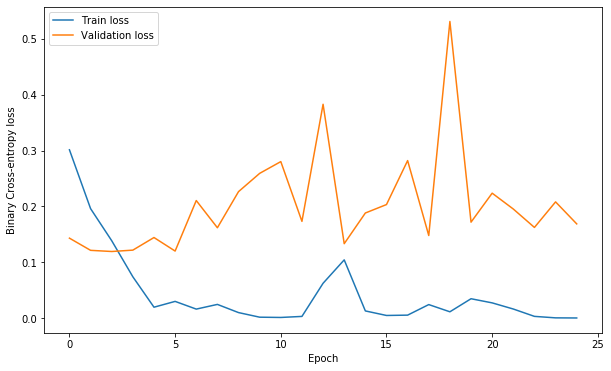

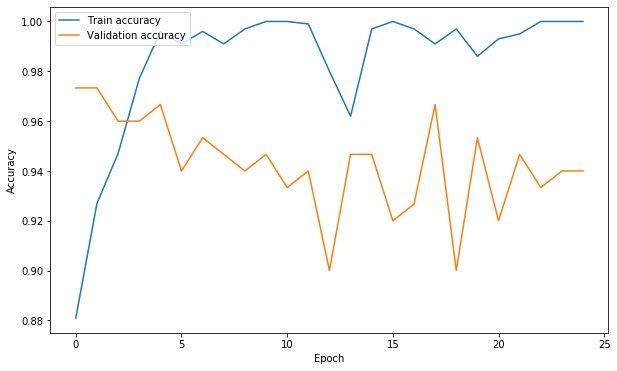

In [12]:
make_plots(train_losses, val_losses, train_accs, val_accs)

## Experiment 2
### Training: 200 positive (113 real + 87 generated) and 800 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative

In [13]:
train_real, test_real = train_test_split(real_wakes, test_size=0.2, random_state=RS)
train_gen, test_gen = train_test_split(generated_wakes, train_size = 0.087, test_size=0.046, random_state=RS)
train_neg, test_neg = train_test_split(not_wakes, train_size = 800/3000, test_size = 75/3000, random_state = RS)
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = np.append(train_real, train_gen, axis = 0)
test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
train_y = np.append(train_pos_y, train_neg_y, axis = 0)
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [14]:
test_dataset.tensors[0].shape

torch.Size([150, 4, 28, 60])

In [15]:
resnet_2 = None
resnet_2 = rn.ResNet18()
train_losses, val_losses, train_accs, val_accs = train_rn(resnet_2, train_dataset, test_dataset, num_epochs = num_epochs, learning_rate=1e-4)

Epoch:1, Loss:0.2800, Val Loss:0.3274, Train Acc:0.902000, Val Acc:0.8333
Epoch:2, Loss:0.1581, Val Loss:0.3694, Train Acc:0.946000, Val Acc:0.8067
Epoch:3, Loss:0.1156, Val Loss:0.2291, Train Acc:0.956000, Val Acc:0.9333
Epoch:4, Loss:0.0548, Val Loss:0.2402, Train Acc:0.984000, Val Acc:0.9400
Epoch:5, Loss:0.0439, Val Loss:0.2380, Train Acc:0.981000, Val Acc:0.9200
Epoch:6, Loss:0.0462, Val Loss:0.3042, Train Acc:0.990000, Val Acc:0.8867
Epoch:7, Loss:0.0963, Val Loss:0.2219, Train Acc:0.966000, Val Acc:0.9333
Epoch:8, Loss:0.0256, Val Loss:0.1840, Train Acc:0.990000, Val Acc:0.9600
Epoch:9, Loss:0.0217, Val Loss:0.2064, Train Acc:0.992000, Val Acc:0.9600
Epoch:10, Loss:0.0298, Val Loss:0.2192, Train Acc:0.991000, Val Acc:0.9533
Epoch:11, Loss:0.0321, Val Loss:0.1810, Train Acc:0.989000, Val Acc:0.9533
Epoch:12, Loss:0.0035, Val Loss:0.2442, Train Acc:1.000000, Val Acc:0.9467
Epoch:13, Loss:0.0017, Val Loss:0.2512, Train Acc:1.000000, Val Acc:0.9400
Epoch:14, Loss:0.0026, Val Loss:0.

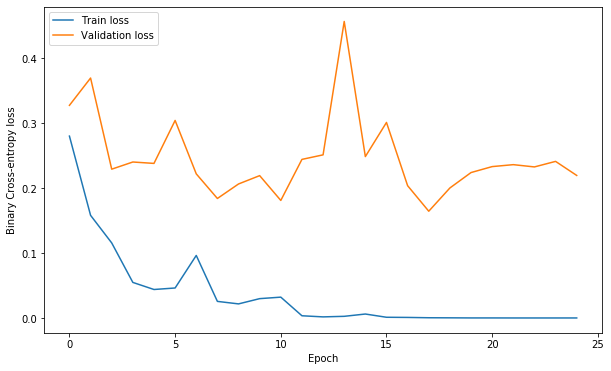

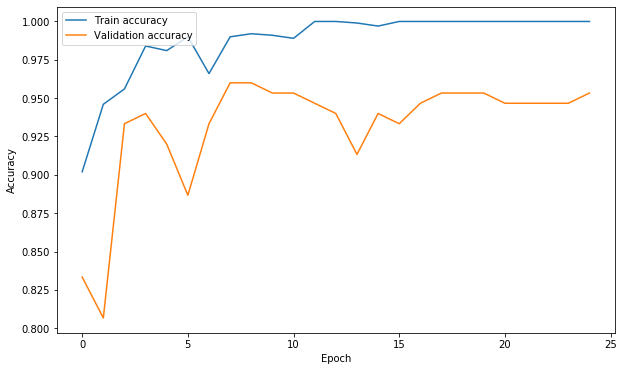

In [16]:
make_plots(train_losses, val_losses, train_accs, val_accs)

## Experiment 3
### Training: 100 positive (100 real) and 900 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative

In [17]:
train_real, test_real = train_test_split(real_wakes, train_size = 100/142, test_size=0.2, random_state=RS)
train_gen, test_gen = train_test_split(generated_wakes, train_size = 0.087, test_size=0.046, random_state=RS)
train_neg, test_neg = train_test_split(not_wakes, train_size = 900/3000, test_size = 75/3000, random_state = RS)
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = train_real
#train_pos = np.append(train_real, train_gen, axis = 0)
test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
train_y = np.append(train_pos_y, train_neg_y, axis = 0)
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [18]:
train_dataset.tensors[0].shape

torch.Size([1000, 4, 28, 60])

In [19]:
resnet_3 = None
resnet_3 = rn.ResNet18()
train_losses, val_losses, train_accs, val_accs = train_rn(resnet_3, train_dataset, test_dataset, num_epochs = num_epochs, learning_rate=1e-4)

Epoch:1, Loss:0.1994, Val Loss:0.4102, Train Acc:0.937000, Val Acc:0.8067
Epoch:2, Loss:0.1266, Val Loss:0.4433, Train Acc:0.963000, Val Acc:0.7800
Epoch:3, Loss:0.1132, Val Loss:0.7552, Train Acc:0.965000, Val Acc:0.7600
Epoch:4, Loss:0.0728, Val Loss:0.2479, Train Acc:0.980000, Val Acc:0.8933
Epoch:5, Loss:0.0406, Val Loss:0.6320, Train Acc:0.990000, Val Acc:0.8067
Epoch:6, Loss:0.0590, Val Loss:0.4446, Train Acc:0.980000, Val Acc:0.8200
Epoch:7, Loss:0.0123, Val Loss:0.4219, Train Acc:0.997000, Val Acc:0.8600
Epoch:8, Loss:0.0219, Val Loss:0.9559, Train Acc:0.991000, Val Acc:0.7600
Epoch:9, Loss:0.0504, Val Loss:0.2530, Train Acc:0.985000, Val Acc:0.9267
Epoch:10, Loss:0.0299, Val Loss:0.6678, Train Acc:0.990000, Val Acc:0.8200
Epoch:11, Loss:0.0076, Val Loss:0.5435, Train Acc:0.999000, Val Acc:0.8533
Epoch:12, Loss:0.0012, Val Loss:0.4929, Train Acc:1.000000, Val Acc:0.8867
Epoch:13, Loss:0.0008, Val Loss:0.4726, Train Acc:1.000000, Val Acc:0.8933
Epoch:14, Loss:0.0004, Val Loss:0.

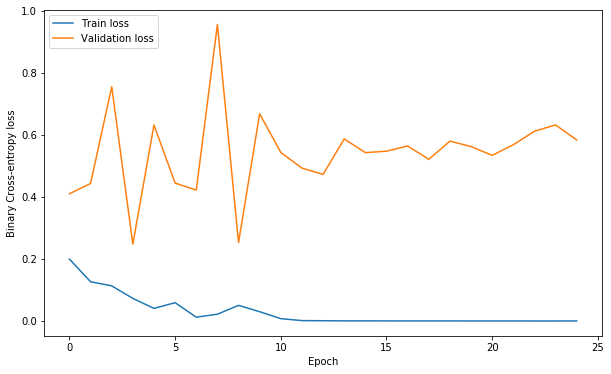

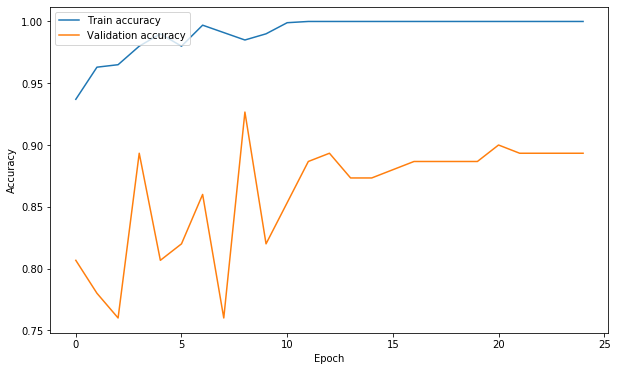

In [20]:
make_plots(train_losses, val_losses, train_accs, val_accs)

## Experiment 4
### Training: 50 positive (50 real) and 950 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative

In [21]:
train_real, test_real = train_test_split(real_wakes, train_size = 50/142, test_size=0.2, random_state=RS)
train_gen, test_gen = train_test_split(generated_wakes, train_size = 0.087, test_size=0.046, random_state=RS)
train_neg, test_neg = train_test_split(not_wakes, train_size = 950/3000, test_size = 75/3000, random_state = RS)
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = train_real
#train_pos = np.append(train_real, train_gen, axis = 0)
test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
train_y = np.append(train_pos_y, train_neg_y, axis = 0)
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [22]:
resnet_4 = None
resnet_4 = rn.ResNet18()
train_losses, val_losses, train_accs, val_accs = train_rn(resnet_4, train_dataset, test_dataset, num_epochs = num_epochs, learning_rate=1e-4)

Epoch:1, Loss:0.1627, Val Loss:0.6247, Train Acc:0.959000, Val Acc:0.6467
Epoch:2, Loss:0.1092, Val Loss:0.6297, Train Acc:0.974000, Val Acc:0.6867
Epoch:3, Loss:0.0942, Val Loss:0.6781, Train Acc:0.968000, Val Acc:0.7467
Epoch:4, Loss:0.0688, Val Loss:0.8963, Train Acc:0.973000, Val Acc:0.6667
Epoch:5, Loss:0.0596, Val Loss:1.0622, Train Acc:0.981000, Val Acc:0.6867
Epoch:6, Loss:0.0319, Val Loss:0.9903, Train Acc:0.990000, Val Acc:0.7000
Epoch:7, Loss:0.0286, Val Loss:0.7296, Train Acc:0.990000, Val Acc:0.7933
Epoch:8, Loss:0.0296, Val Loss:0.6087, Train Acc:0.991000, Val Acc:0.7733
Epoch:9, Loss:0.0171, Val Loss:0.7220, Train Acc:0.994000, Val Acc:0.7467
Epoch:10, Loss:0.0439, Val Loss:0.9599, Train Acc:0.987000, Val Acc:0.7667
Epoch:11, Loss:0.0079, Val Loss:0.7119, Train Acc:0.998000, Val Acc:0.7867
Epoch:12, Loss:0.0098, Val Loss:0.9974, Train Acc:0.997000, Val Acc:0.7200
Epoch:13, Loss:0.0160, Val Loss:0.7914, Train Acc:0.996000, Val Acc:0.7333
Epoch:14, Loss:0.0035, Val Loss:0.

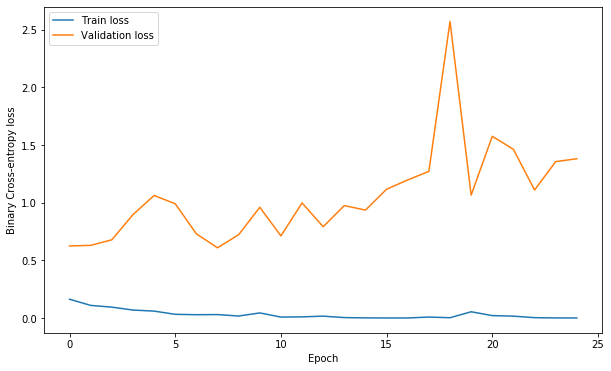

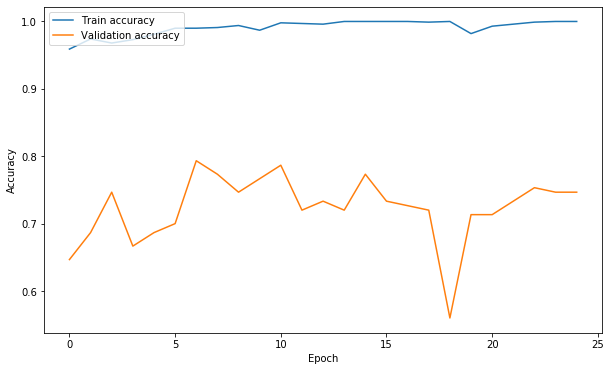

In [23]:
make_plots(train_losses, val_losses, train_accs, val_accs)

## Experiment 5
### Training: 25 positive (25 real) and 975 negative 
### Test: 75 positive (29 real + 46 generated) and 75 negative

In [24]:
train_real, test_real = train_test_split(real_wakes, train_size = 25/142, test_size=0.2, random_state=RS)
train_gen, test_gen = train_test_split(generated_wakes, train_size = 0.087, test_size=0.046, random_state=RS)
train_neg, test_neg = train_test_split(not_wakes, train_size = 975/3000, test_size = 75/3000, random_state = RS)
test_pos = np.append(test_real, test_gen, axis = 0)
train_pos = train_real
#train_pos = np.append(train_real, train_gen, axis = 0)
test_x = np.append(test_pos, test_neg, axis = 0)
train_x = np.append(train_pos, train_neg, axis = 0)
test_pos_y = np.concatenate((np.ones(test_pos.shape[0]).reshape(-1,1), np.zeros(test_pos.shape[0]).reshape(-1,1)), axis = 1)
test_neg_y = np.concatenate((np.zeros(test_neg.shape[0]).reshape(-1,1), np.ones(test_neg.shape[0]).reshape(-1,1)), axis = 1)
train_pos_y = np.concatenate((np.ones(train_pos.shape[0]).reshape(-1,1), np.zeros(train_pos.shape[0]).reshape(-1,1)), axis = 1)
train_neg_y = np.concatenate((np.zeros(train_neg.shape[0]).reshape(-1,1), np.ones(train_neg.shape[0]).reshape(-1,1)), axis = 1)
test_y = np.append(test_pos_y, test_neg_y, axis = 0)
train_y = np.append(train_pos_y, train_neg_y, axis = 0)
train_dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))

In [25]:
resnet_4 = None
resnet_4 = rn.ResNet18()
train_losses, val_losses, train_accs, val_accs = train_rn(resnet_4, train_dataset, test_dataset, num_epochs = num_epochs, learning_rate=1e-4)

Epoch:1, Loss:0.1121, Val Loss:1.0868, Train Acc:0.977000, Val Acc:0.6400
Epoch:2, Loss:0.0663, Val Loss:1.0288, Train Acc:0.983000, Val Acc:0.6667
Epoch:3, Loss:0.0530, Val Loss:1.0561, Train Acc:0.986000, Val Acc:0.6533
Epoch:4, Loss:0.0389, Val Loss:0.9180, Train Acc:0.989000, Val Acc:0.7200
Epoch:5, Loss:0.0237, Val Loss:1.0621, Train Acc:0.993000, Val Acc:0.6800
Epoch:6, Loss:0.0093, Val Loss:0.9214, Train Acc:0.998000, Val Acc:0.7667
Epoch:7, Loss:0.0016, Val Loss:1.3753, Train Acc:1.000000, Val Acc:0.6933
Epoch:8, Loss:0.0010, Val Loss:1.3575, Train Acc:1.000000, Val Acc:0.6933
Epoch:9, Loss:0.0003, Val Loss:1.4492, Train Acc:1.000000, Val Acc:0.6867
Epoch:10, Loss:0.0002, Val Loss:1.3910, Train Acc:1.000000, Val Acc:0.7000
Epoch:11, Loss:0.0002, Val Loss:1.4617, Train Acc:1.000000, Val Acc:0.7000
Epoch:12, Loss:0.0002, Val Loss:1.5732, Train Acc:1.000000, Val Acc:0.6867
Epoch:13, Loss:0.0001, Val Loss:1.4874, Train Acc:1.000000, Val Acc:0.6933
Epoch:14, Loss:0.0001, Val Loss:1.

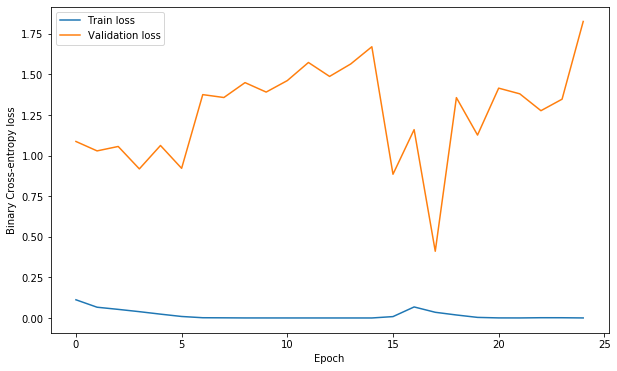

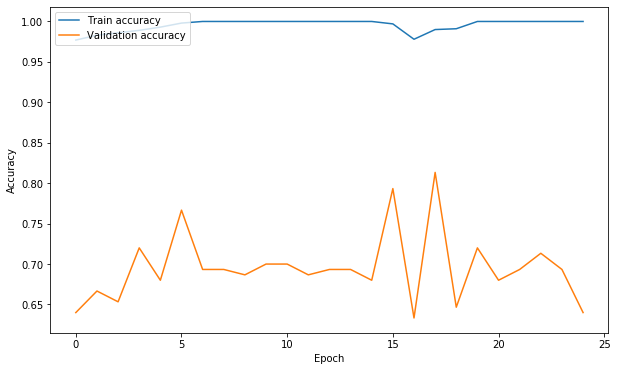

In [26]:
make_plots(train_losses, val_losses, train_accs, val_accs)

In [27]:
1

1